In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datassist import explore, graph

In [2]:
rng = np.random.RandomState(42)

# EDA

## Inital Exploration

In [3]:
df_wine = pd.read_csv('data/winequality-white (2).csv')
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df_wine.shape

(4898, 12)

In [5]:
explore.overview(df_wine)

,NULL Count,Unique Items,Type
fixed acidity,0,68,float64
volatile acidity,0,125,float64
citric acid,0,87,float64
residual sugar,0,310,float64
chlorides,0,160,float64
free sulfur dioxide,0,132,float64
total sulfur dioxide,0,251,float64
density,0,890,float64
pH,0,103,float64
sulphates,0,79,float64


In [6]:
explore.basic_stats(df_wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0
mean,6.9,0.3,0.3,6.4,0.0,35.3,138.4,1.0,3.2,0.5,10.5,5.9
std,0.8,0.1,0.1,5.1,0.0,17.0,42.5,0.0,0.2,0.1,1.2,0.9
min,3.8,0.1,0.0,0.6,0.0,2.0,9.0,1.0,2.7,0.2,8.0,3.0
25%,6.3,0.2,0.3,1.7,0.0,23.0,108.0,1.0,3.1,0.4,9.5,5.0
50%,6.8,0.3,0.3,5.2,0.0,34.0,134.0,1.0,3.2,0.5,10.4,6.0
75%,7.3,0.3,0.4,9.9,0.0,46.0,167.0,1.0,3.3,0.6,11.4,6.0
max,14.2,1.1,1.7,65.8,0.3,289.0,440.0,1.0,3.8,1.1,14.2,9.0
median,6.8,0.3,0.3,5.2,0.0,34.0,134.0,1.0,3.2,0.5,10.4,6.0
mode,6.8,0.3,0.3,1.2,0.0,29.0,111.0,1.0,3.1,0.5,9.4,6.0


In [7]:
sorted(df_wine['quality'].unique())

[3, 4, 5, 6, 7, 8, 9]

From an initial examination, we have 7 unique labels for the data (3 to 9)

This begs the  question: should we use the same number of clusters as labels? Or should we use 10 clusters, since the labels seem to lie on an incomplete scale (either 0-9 or 1-10)?

Already we are biased by the knowledge of the labels...

## Feature Distributions

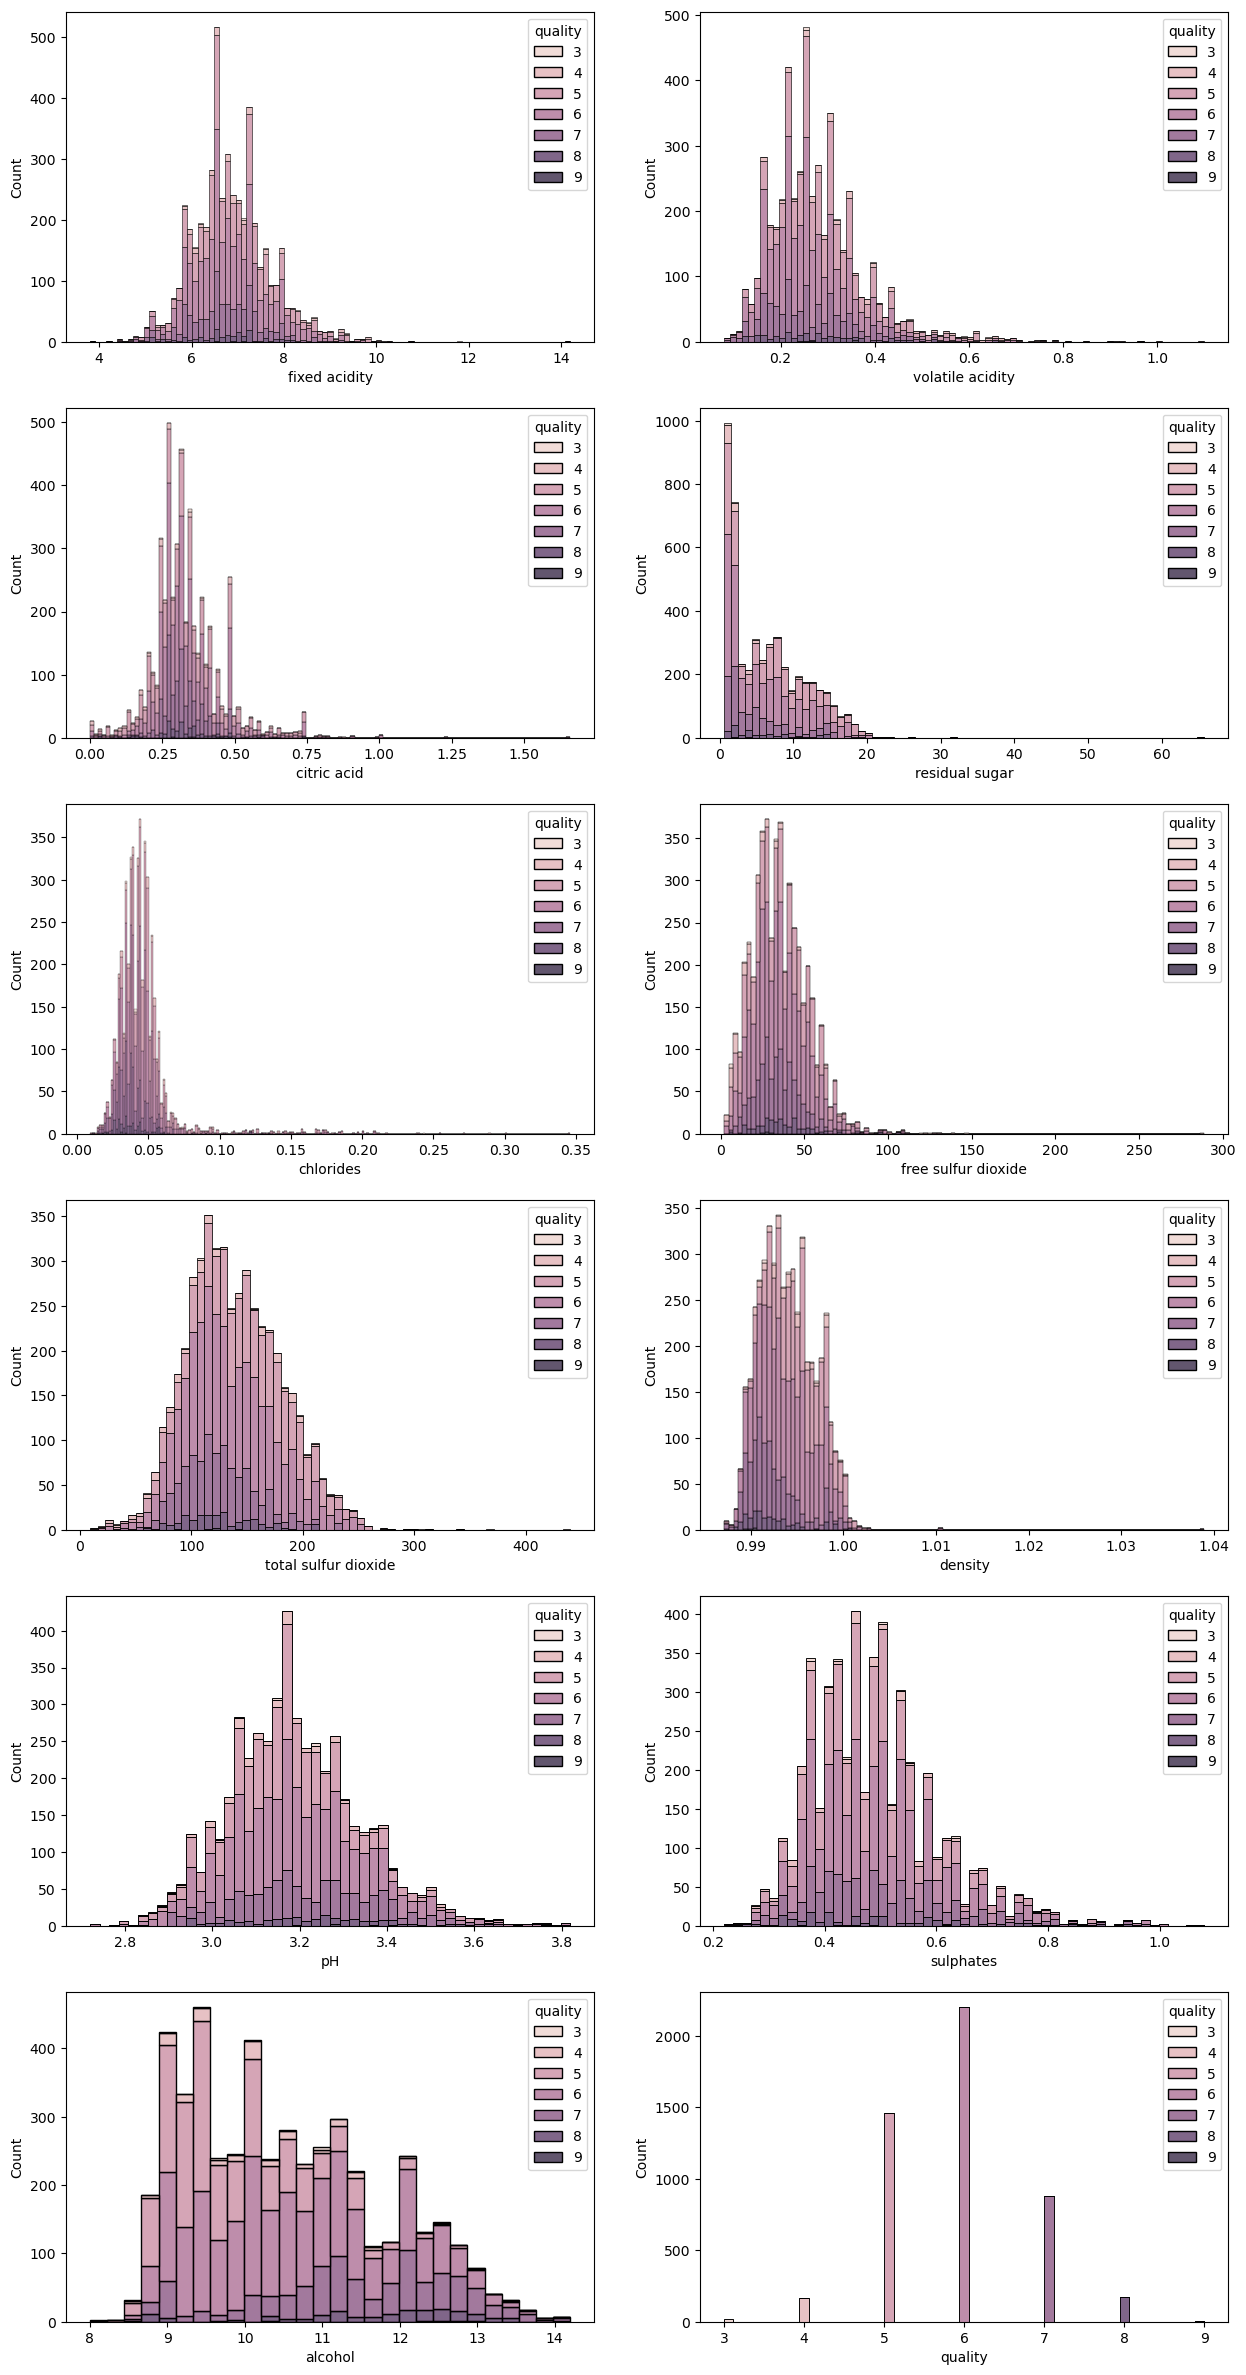

In [8]:
graph.plot_hist_of_numeric(df_wine, n_cols=2, category_col='quality')

Many of these plots seem to have reasonable distributions, but with long tails

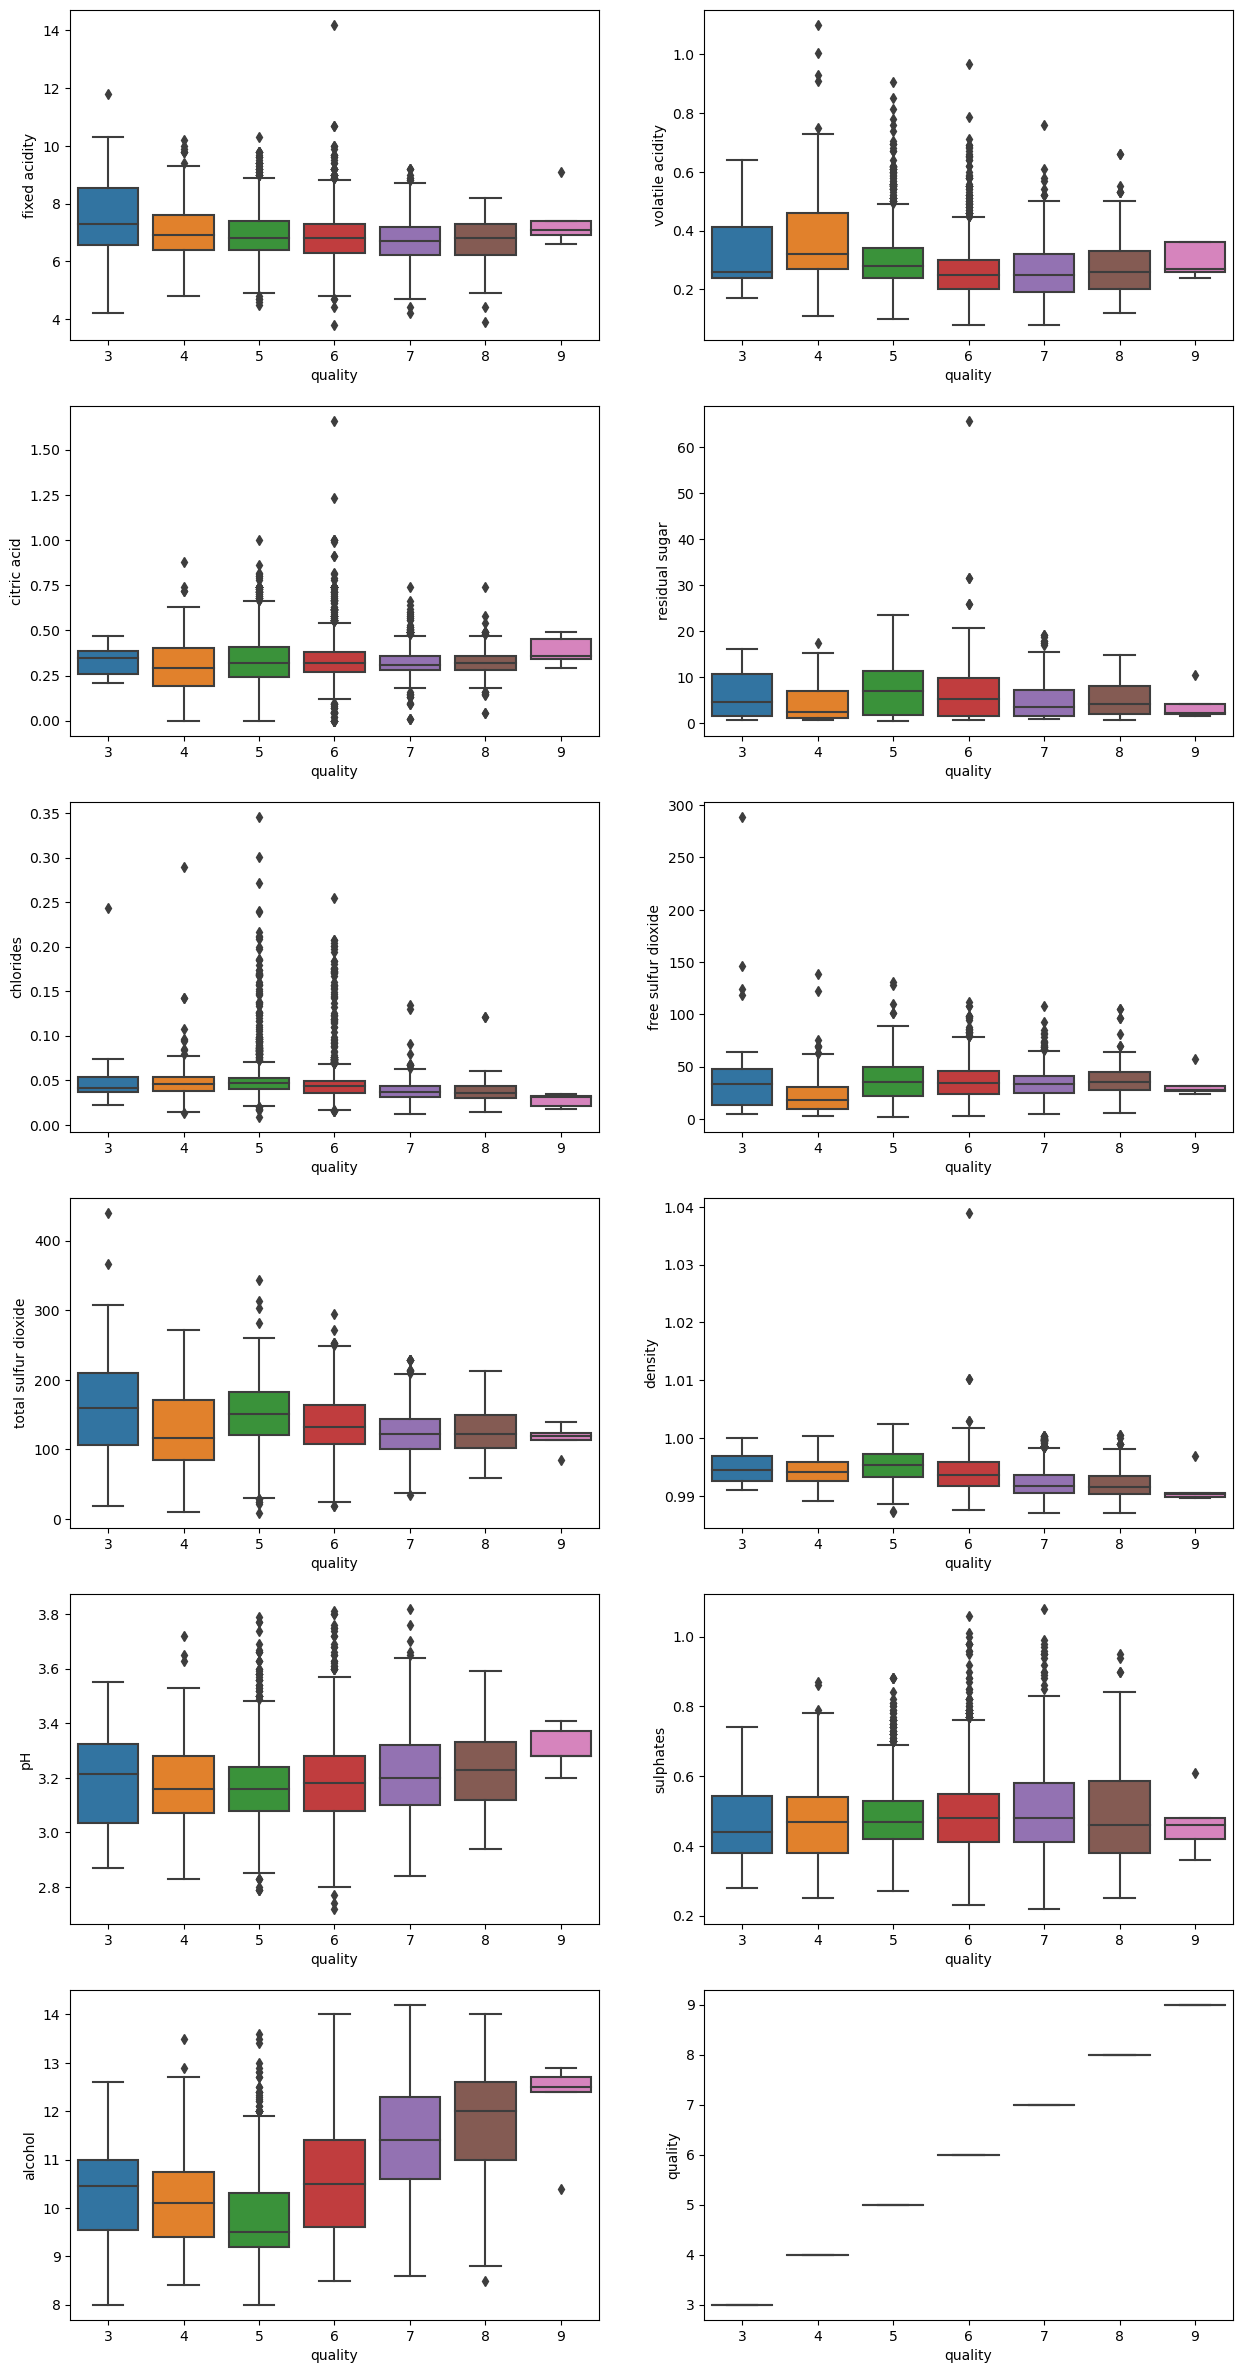

In [9]:
graph.plot_box_of_numeric(df_wine, n_cols=2, category_col='quality')

It seems to be quality ratings 5 and 6 that have the most extreme outliers in most features, the rest generally lie within similar ranges (except for the alcohol content feature)

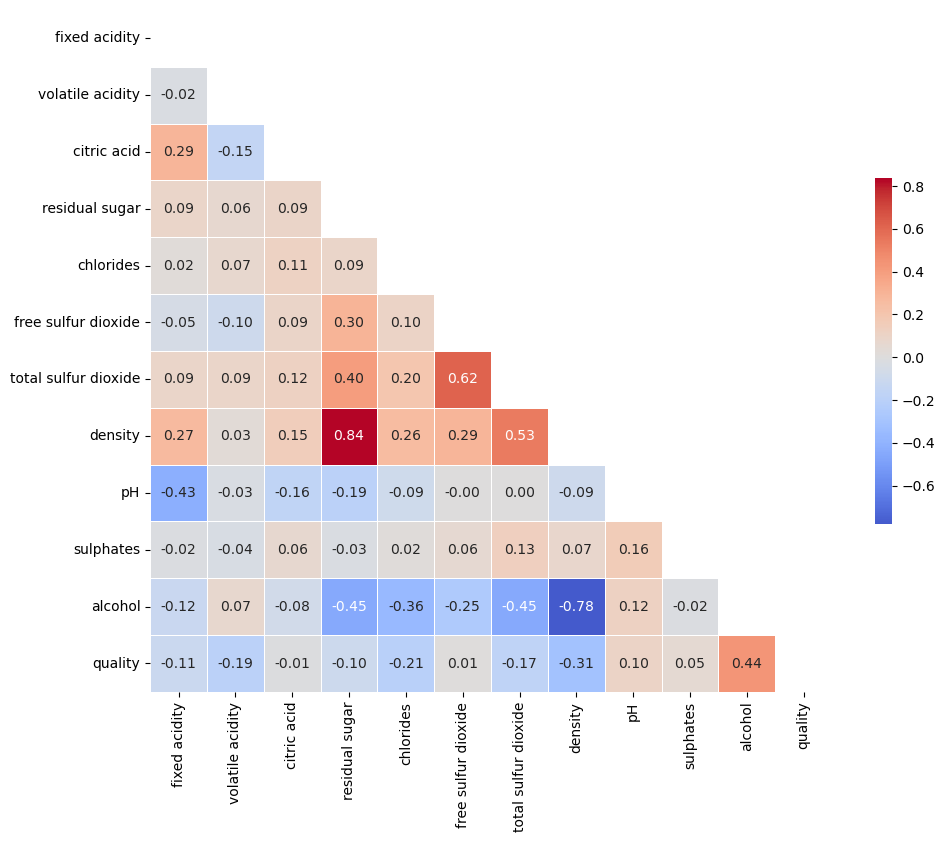

In [10]:
graph.plot_correlation_matrix(df_wine)

So it seems that quality, density then chlorides are the top three indicators of wine quality

## Plot the clusters

In [11]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [12]:
# PCA Pipeline
N_DIMS = 3

pipe_stages = [
    ('scaler', QuantileTransformer(output_distribution='normal')),
    ('pca', PCA(n_components=N_DIMS)),
]

pipe_pca = Pipeline(pipe_stages)

In [13]:
def plot_decomposed_features_3d(df_decomposed: pd.DataFrame, labels: pd.Series, fig_size: int = 15):
    if df_decomposed.shape[1] != 3:
        raise ValueError('df_decomposed should have 3 columns')
    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot(111, projection='3d')
    handles = ax.scatter(df_decomposed[:, 0], df_decomposed[:, 1], df_decomposed[:, 2], c=labels, alpha=0.7, cmap='inferno')
    # plot legend
    ax.legend(*handles.legend_elements(), title=labels.name, loc='best')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

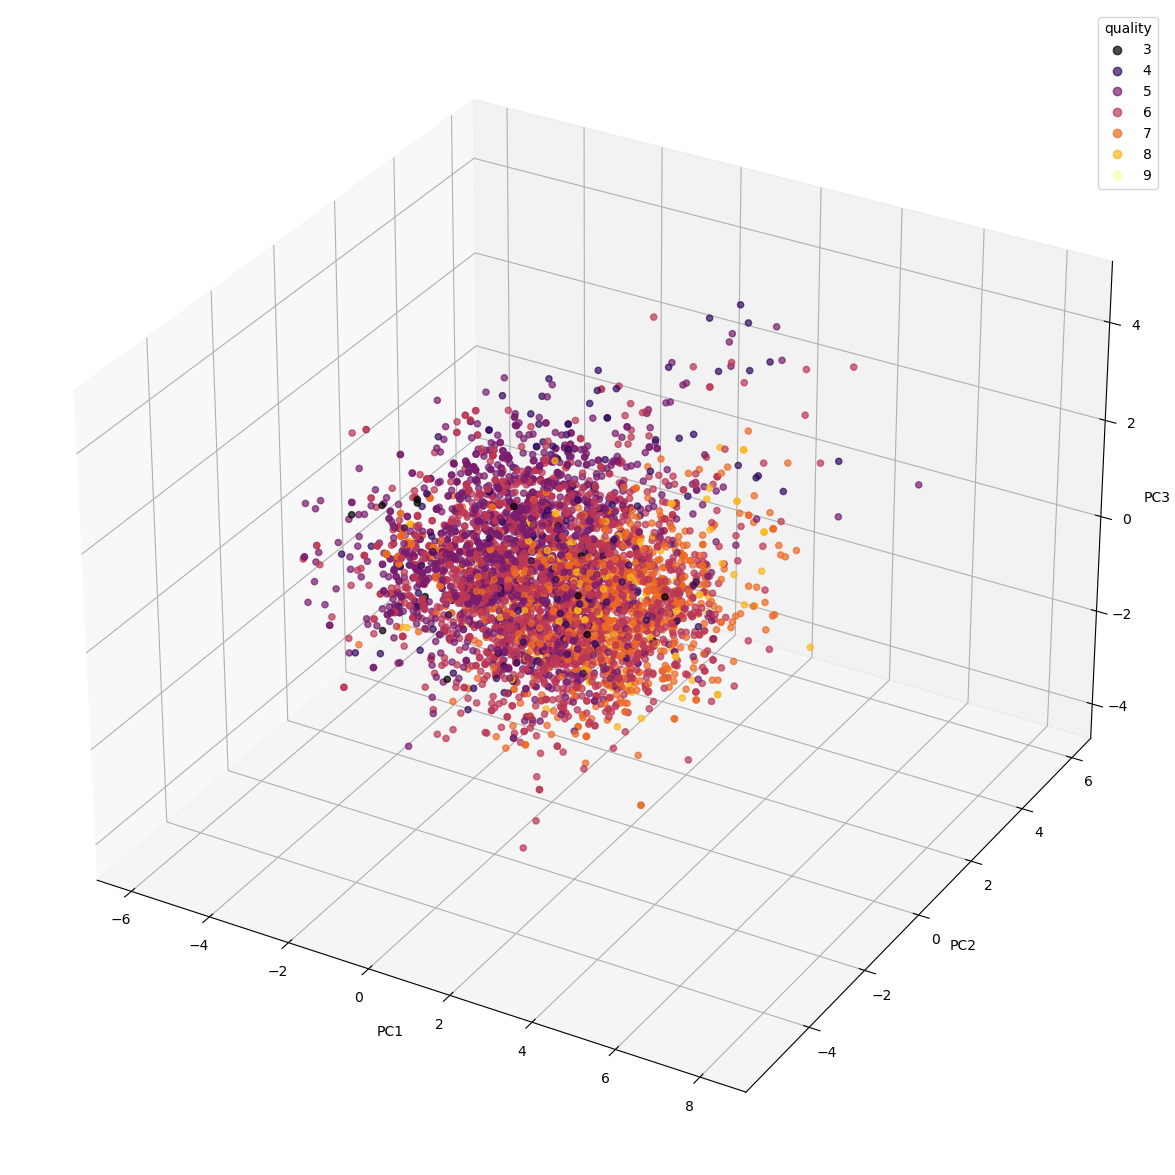

In [14]:
plot_decomposed_features_3d(
    pipe_pca.fit_transform(df_wine.drop(columns='quality')),
    df_wine['quality'],
)

I was hoping to see more defined boundaries between wine quality ratings but this just looks like one big blob... :'(

- Although there is a trend that the wine quality rating seems to increase from left to right, the ratings are very close together so there may not be consistent or definitive clustering
- There are also a few outliers which belong to many labels (top-right of graph) so they may be clustered together

In [15]:
pipe_pca.named_steps['pca'].explained_variance_ratio_

array([0.30431313, 0.14697879, 0.11450728])

### Is T-SNE any better for visualising?

In [16]:
from sklearn.manifold import TSNE

In [17]:
# TSNE Pipeline

pipe_stages = [
    ('scaler', QuantileTransformer(output_distribution='normal')),
    ('tsne', TSNE(n_components=N_DIMS, random_state=rng)),
]

pipe_tsne = Pipeline(pipe_stages)

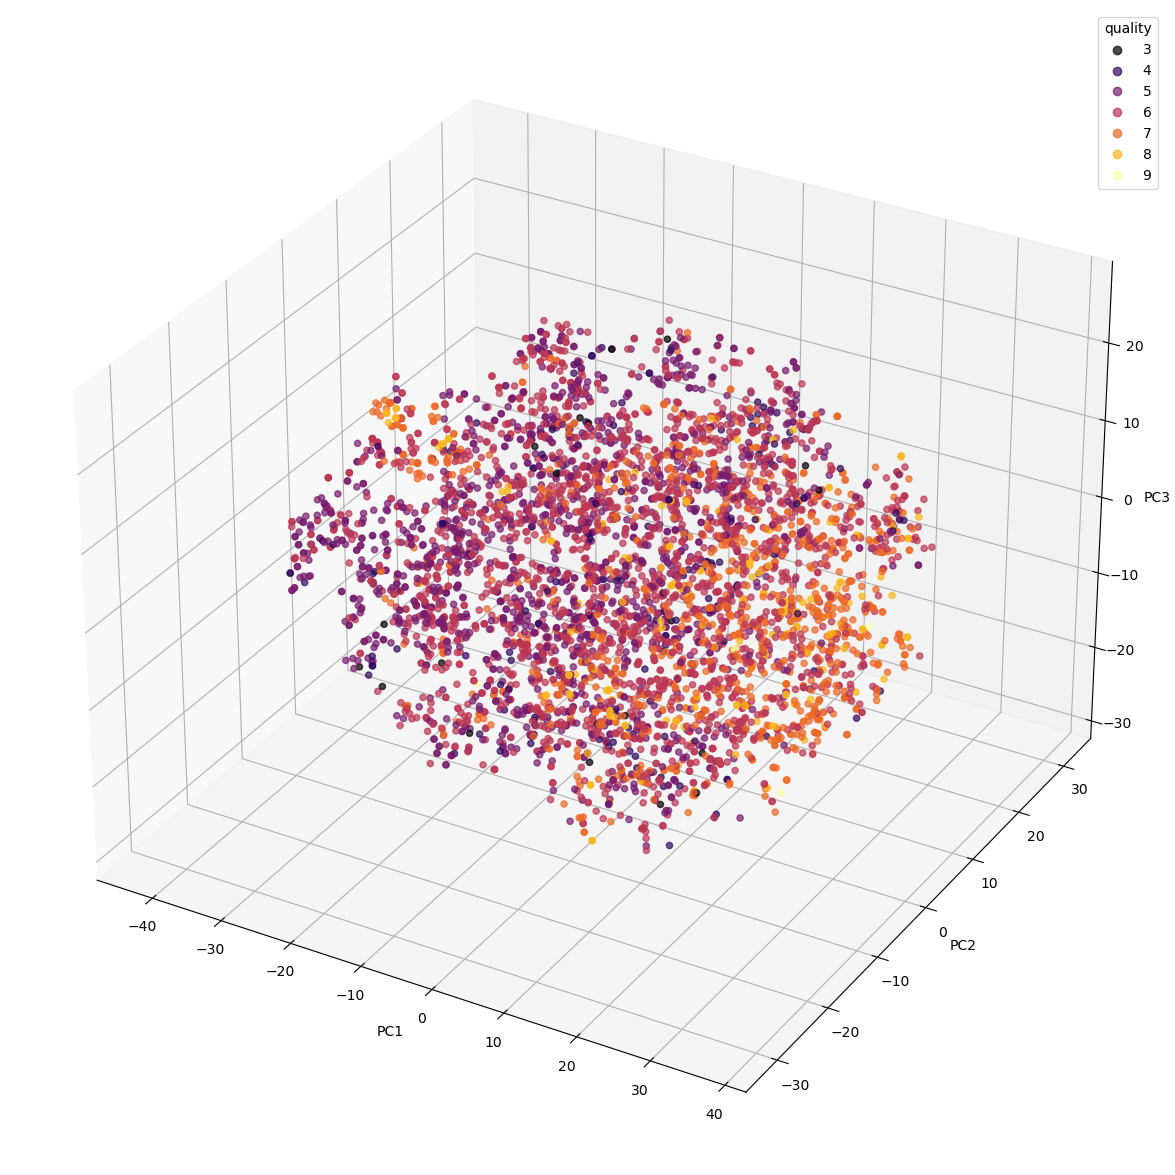

In [18]:
plot_decomposed_features_3d(
    pipe_tsne.fit_transform(df_wine.drop(columns='quality')),
    df_wine['quality'],
)

This is also very blobby...